# Welcome to House Price Prediction Party

## GroupName: WeIsExpert
## GroupMember:

- CHAN Kai Kin
- CHEN Jian
- WU Kangzhang
- LEE Lip Tong

## Coder & Speaker: *WU Kangzhang*
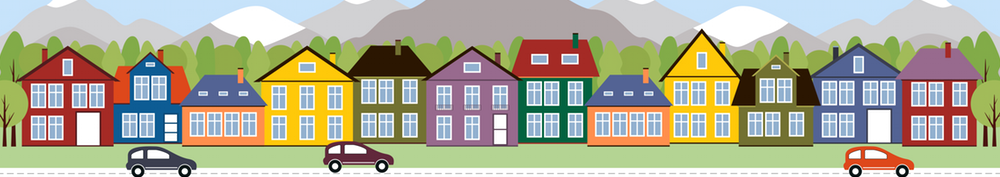
## Step 1. Download the data from Kaggle [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
### File descriptions
- train.csv - the training set
- test.csv - the test set

Here we have all the csv files and you can download by yourself.

Before reading the data, we import some necessary python libraries.

------

In [ ]:
import numpy as np
import pandas as pd
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns

Then we read the train.csv and test.csv files by using pandas.

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
# the initial feature
train.columns

## Step 2. Data Cleaning

Features which have large porpotion of missing data can be dropped.

Before doing this, we have to figure out which feature has too many missing data.

We calculate the porportion of missing data and rank them into descengding order.

In [ ]:
#missing data in train dataset
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# MiscFeature: Miscellaneous feature not covered in other categories

It is visible to have a globol view on our dataset by using libray of `missingo`

You may should `pip install missingo` it before using it.

In [ ]:
import missingno as msno
msno.matrix(df=pd.concat([train,test]), color=(0.5,0,0))

We want to **drop the features** which have more than 1 missing data. But we can see only have one missing date in the feature of `Electrical` ,so we just delete that one sample.

But for testing dataset,we just delete the same features as training dataset, but replace the missing data with its median.
Please notice that we are going to submit our prediction result to campare with other competitors on kaggle.

We also need to convert some features from `object:String` to `int:numpy.int64` by uisng `sklearn`.

We also **keep ID information** into other variables and then drop them.

In [ ]:
#dealing with missing train data
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)

#filling missing test data with median
test = test.drop((missing_data[missing_data['Total'] > 1]).index,1)
test=test.fillna(test.median())

from sklearn.preprocessing import LabelEncoder
for i in range(train.shape[1]):
    if train.iloc[:,i].dtypes == object:
        lb=LabelEncoder()
        lb.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
        train.iloc[:,i]=lb.transform(list(train.iloc[:,i].values))
        test.iloc[:,i]=lb.transform(list(test.iloc[:,i].values))

# keep ID for submission
train_ID = train['Id']
test_ID = test['Id']
train=train.drop('Id',axis=1)
test=test.drop('Id',axis=1)

In [ ]:
# We can see how many testing samples
len(test)

How about look at the correlation heat map first? It is useful to give our a first impression of the importances of all features.

In [ ]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corrmat,square=True,vmax=0.8)

## Step 3. Split the training dataset
Then we split the training data into `Y` and `X`, `Y` refers to our regression target variable, and `X` refers to the input of our regressor.

Then we can look at the global view of our dataset again to check the missing condition.

In [ ]:
Y_train = train['SalePrice']
X_train = train.drop(['SalePrice'], axis=1)

#import missingno as msno
msno.matrix(df=pd.concat([X_train,test]), color=(0.5,0,0))

How about the number of features?

In [ ]:
n_feature_dataset=len(X_train.columns)
n_feature_dataset

## Step 4. Training using Random Forest algorithm
Then we start using **Random Forest** in sit-kit learn to do regression.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

**Then we initialize a random forest regressor with our best parameters, with:**

- The number of trees : 1000
- Criterion of measuring lose function : Mean Square Error
- The number of features to consider when looking for the best split : 40

In [ ]:
regre=RandomForestRegressor(n_estimators=1000,criterion='mse',max_features=40,n_jobs=-1,oob_score=True,random_state=2)

In [ ]:
regre.fit(X_train.values,Y_train.values)

Using **the Coefficient of Variation with Root-Mean-Square Deviation (*CV_RMSD*)** to measure our regressor.

$$RMSD=\sqrt{\frac{\sum_{t=1}^{T} ({\hat{y_t}-y_t})^2}{n}}$$

$$CV(RMSD)=\frac{RMSD}{\overline{y}}$$

In [ ]:
def cv_rmsd(y,y_pred):
    y=y.values
    return np.sqrt(((y_pred-y)**2).sum()/len(y))/y.mean()

In [ ]:
Y_train_pred=regre.predict(X_train.values)
cv_rmsd(Y_train,Y_train_pred)

In order to visulize our random forest regressor, campare it with linear regressor,let's choose the feature with highest correlation with sale price,refer to heat map,that is `OverallQual` and `YearBuilt`.

We need to train another random forest regressor.

In [ ]:
regre0=RandomForestRegressor(n_estimators=100,criterion='mae',n_jobs=-1,oob_score=True)
regre0.fit(X_train['OverallQual'].values.reshape(-1,1),Y_train.values)
regre1=RandomForestRegressor(n_estimators=100,criterion='mae',n_jobs=-1,oob_score=True)
regre1.fit(X_train['YearBuilt'].values.reshape(-1,1),Y_train.values)

In [ ]:
y_pred_byOverallQual=regre0.predict(X_train['OverallQual'].values.reshape(-1,1))
print('The CV_RMSD of regression with OverallQual:%s'% cv_rmsd(Y_train,y_pred_byOverallQual))
y_pred_byYearBuilt=regre1.predict(X_train['YearBuilt'].values.reshape(-1,1))
print('The CV_RMSD of regression with YearBuilt:%s'% cv_rmsd(Y_train,y_pred_byYearBuilt))

To make it visiable:

In [ ]:
fig=plt.figure(figsize=(14,10))
sns.regplot(x=X_train['OverallQual'], y=Y_train,marker='.',color='y')
x=np.random.randint(low=0,high=11,size=20).reshape(-1,1)
y=regre0.predict(x)
sns.regplot(x=x,y=y,fit_reg=False,color='r')

In [ ]:
fig=plt.figure(figsize=(14,10))
sns.regplot(x=X_train['YearBuilt'], y=Y_train,color='grey',marker='.')
x=np.random.randint(low=1870,high=2010,size=1000).reshape(-1,1)
y=regre1.predict(x)
sns.regplot(x=x,y=y,fit_reg=False,color='r',marker='.')

## Step 5. Predicting
**Then we can predict all the sale prices of testing samples:**

In [ ]:
Y_test_pred=regre.predict(test.values)

## Step 6. Submit to Kaggle to measure the performance
**Finally we write it into a csv file and submit it to kaggle to check our result**

In [ ]:
def output(filename):
    fw=open(filename,'w')
    fw.write('Id,SalePrice\n\n')
    for i in range(len(test_ID)):
        fw.write(str(test_ID.values[i])+','+str(Y_test_pred[i])+'\n')
    fw.close()

#output('submission.csv')

# Yahoo!! We performed better than half of people.
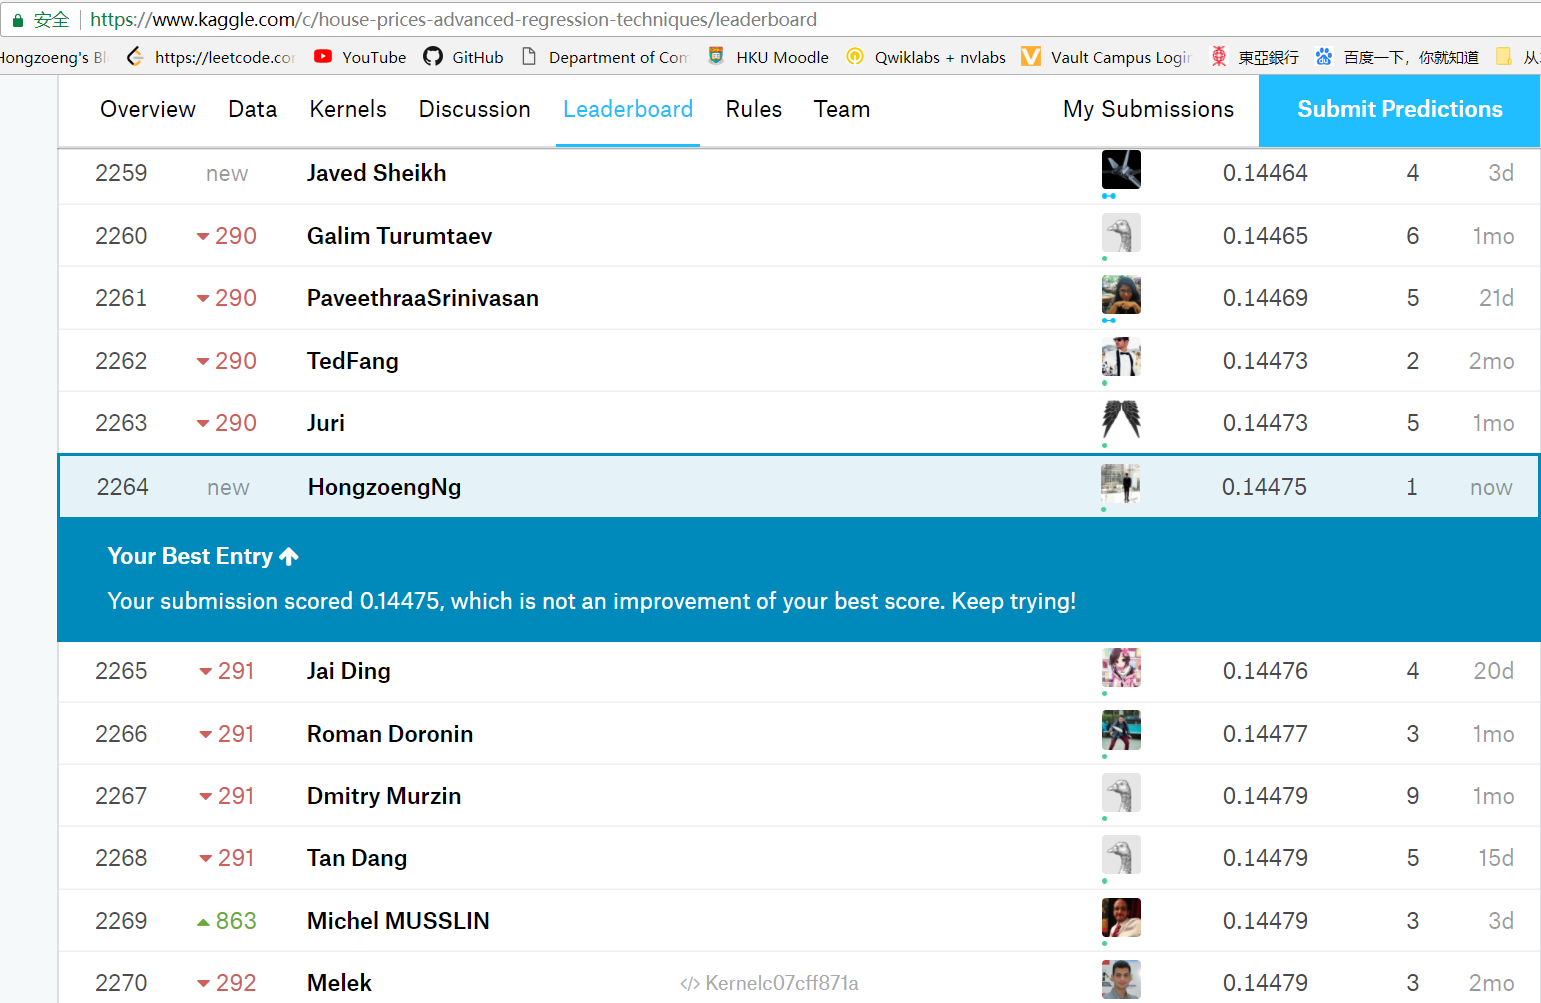
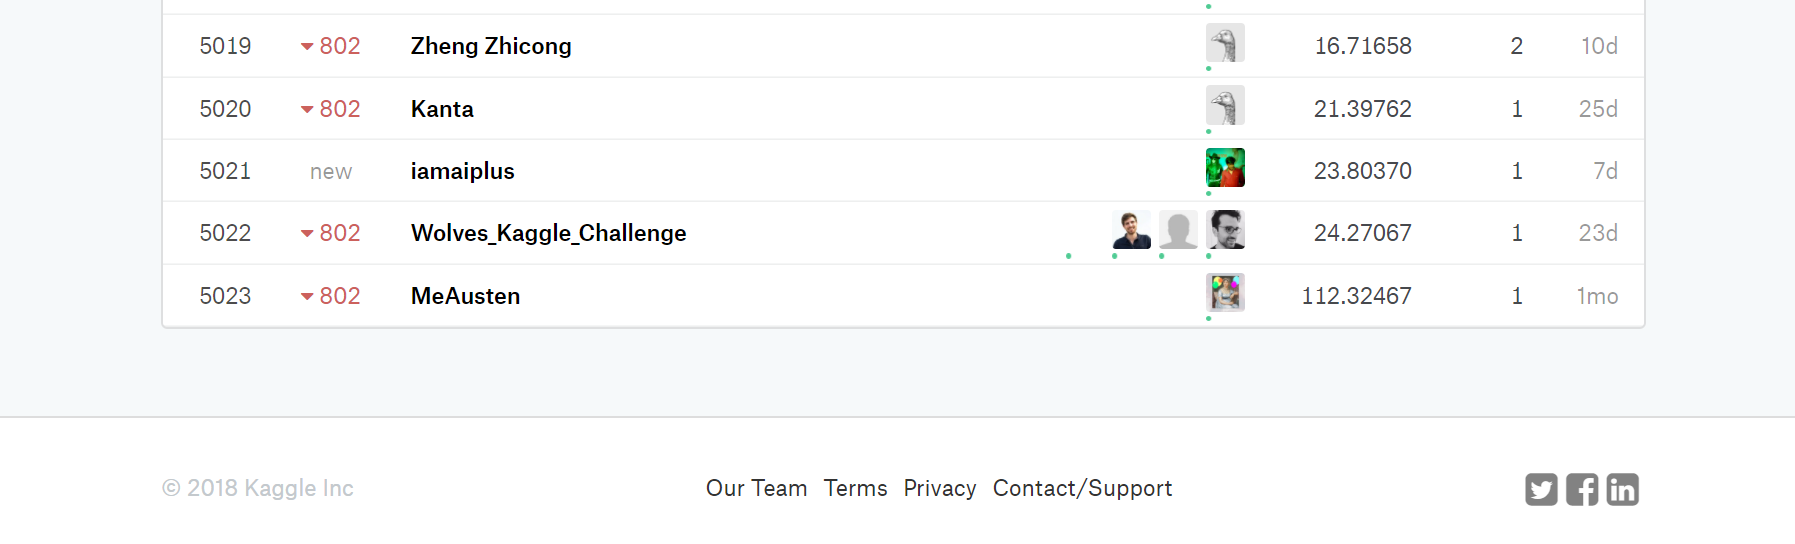